# Анализ метрик бенчмарка Multi-Agent системы

Этот ноутбук содержит анализ метрик, собранных из базы данных `benchmark-standalone/data/metrics.db`.

## Содержание
1. Подключение к базе данных
2. Обзор данных
3. Анализ экспериментов
4. Анализ выполнения задач
5. Анализ LLM вызовов
6. Анализ использования инструментов
7. Анализ переключений агентов
8. Оценка качества
9. Выводы и рекомендации

In [1]:
!pip install pandas matplotlib seaborn

In [2]:
# Импорт необходимых библиотек
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Подавление предупреждений
import warnings
warnings.filterwarnings('ignore')

print("✓ Библиотеки импортированы успешно")

✓ Библиотеки импортированы успешно


## 1. Подключение к базе данных

In [3]:
# Путь к базе данных
DB_PATH = '../benchmark-standalone/data/metrics.db'

# Подключение к базе данных
conn = sqlite3.connect(DB_PATH)
print(f"✓ Подключено к базе данных: {DB_PATH}")

# Получение списка таблиц
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
print(f"\nТаблицы в базе данных:")
for table in tables['name']:
    print(f"  - {table}")

✓ Подключено к базе данных: ../benchmark-standalone/data/metrics.db

Таблицы в базе данных:
  - poc_experiments
  - poc_task_executions
  - poc_llm_calls
  - poc_tool_calls
  - poc_agent_switches
  - poc_quality_evaluations
  - poc_hallucinations


## 2. Обзор данных

In [4]:
# Загрузка данных из всех таблиц
experiments_df = pd.read_sql_query("SELECT * FROM poc_experiments", conn)
task_executions_df = pd.read_sql_query("SELECT * FROM poc_task_executions", conn)
llm_calls_df = pd.read_sql_query("SELECT * FROM poc_llm_calls", conn)
tool_calls_df = pd.read_sql_query("SELECT * FROM poc_tool_calls", conn)
agent_switches_df = pd.read_sql_query("SELECT * FROM poc_agent_switches", conn)
quality_evaluations_df = pd.read_sql_query("SELECT * FROM poc_quality_evaluations", conn)
hallucinations_df = pd.read_sql_query("SELECT * FROM poc_hallucinations", conn)

print("Количество записей в таблицах:")
print(f"  Эксперименты: {len(experiments_df)}")
print(f"  Выполнения задач: {len(task_executions_df)}")
print(f"  LLM вызовы: {len(llm_calls_df)}")
print(f"  Вызовы инструментов: {len(tool_calls_df)}")
print(f"  Переключения агентов: {len(agent_switches_df)}")
print(f"  Оценки качества: {len(quality_evaluations_df)}")
print(f"  Галлюцинации: {len(hallucinations_df)}")

Количество записей в таблицах:
  Эксперименты: 1
  Выполнения задач: 40
  LLM вызовы: 145
  Вызовы инструментов: 102
  Переключения агентов: 43
  Оценки качества: 39
  Галлюцинации: 0


## 3. Анализ экспериментов

In [5]:
# Преобразование временных меток
experiments_df['started_at'] = pd.to_datetime(experiments_df['started_at'])
experiments_df['completed_at'] = pd.to_datetime(experiments_df['completed_at'])

# Расчет длительности экспериментов
experiments_df['duration_minutes'] = (
    experiments_df['completed_at'] - experiments_df['started_at']
).dt.total_seconds() / 60

print("Статистика по экспериментам:")
print(experiments_df[['mode', 'started_at', 'completed_at', 'duration_minutes']].describe())

# Распределение по режимам
print("\nРаспределение экспериментов по режимам:")
print(experiments_df['mode'].value_counts())

Статистика по экспериментам:
                          started_at                   completed_at  \
count                              1                              1   
mean   2026-01-18 05:55:21.524858112  2026-01-18 06:09:36.348729088   
min       2026-01-18 05:55:21.524858     2026-01-18 06:09:36.348729   
25%    2026-01-18 05:55:21.524858112  2026-01-18 06:09:36.348729088   
50%    2026-01-18 05:55:21.524858112  2026-01-18 06:09:36.348729088   
75%    2026-01-18 05:55:21.524858112  2026-01-18 06:09:36.348729088   
max       2026-01-18 05:55:21.524858     2026-01-18 06:09:36.348729   
std                              NaN                            NaN   

       duration_minutes  
count          1.000000  
mean          14.247065  
min           14.247065  
25%           14.247065  
50%           14.247065  
75%           14.247065  
max           14.247065  
std                 NaN  

Распределение экспериментов по режимам:
mode
multi-agent    1
Name: count, dtype: int64


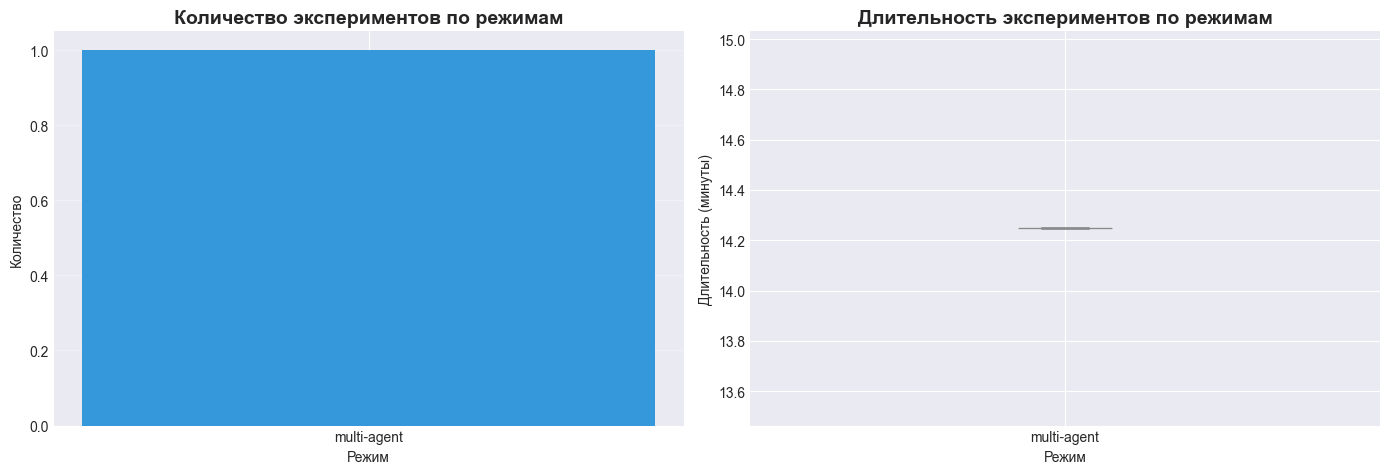

In [6]:
# Визуализация распределения экспериментов по режимам
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Количество экспериментов по режимам
mode_counts = experiments_df['mode'].value_counts()
axes[0].bar(mode_counts.index, mode_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Количество экспериментов по режимам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Режим')
axes[0].set_ylabel('Количество')
axes[0].grid(axis='y', alpha=0.3)

# График 2: Длительность экспериментов по режимам
if not experiments_df['duration_minutes'].isna().all():
    experiments_df.boxplot(column='duration_minutes', by='mode', ax=axes[1])
    axes[1].set_title('Длительность экспериментов по режимам', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Режим')
    axes[1].set_ylabel('Длительность (минуты)')
    plt.suptitle('')
else:
    axes[1].text(0.5, 0.5, 'Нет данных о длительности', 
                ha='center', va='center', fontsize=12)
    axes[1].set_title('Длительность экспериментов по режимам', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Анализ выполнения задач

In [7]:
# Преобразование временных меток
task_executions_df['started_at'] = pd.to_datetime(task_executions_df['started_at'])
task_executions_df['completed_at'] = pd.to_datetime(task_executions_df['completed_at'])

# Расчет длительности задач
task_executions_df['duration_seconds'] = (
    task_executions_df['completed_at'] - task_executions_df['started_at']
).dt.total_seconds()

print("Статистика по выполнению задач:")
print(f"Всего задач: {len(task_executions_df)}")
print(f"Успешных: {task_executions_df['success'].sum()}")
print(f"Неуспешных: {len(task_executions_df) - task_executions_df['success'].sum()}")
print(f"\nУспешность: {task_executions_df['success'].mean() * 100:.2f}%")

print("\nРаспределение по категориям задач:")
print(task_executions_df['task_category'].value_counts())

print("\nРаспределение по типам задач:")
print(task_executions_df['task_type'].value_counts())

Статистика по выполнению задач:
Всего задач: 40
Успешных: 8
Неуспешных: 32

Успешность: 20.00%

Распределение по категориям задач:
task_category
medium         15
simple         10
complex        10
specialized     5
Name: count, dtype: int64

Распределение по типам задач:
task_type
coding          16
debug            9
architecture     8
question         4
mixed            3
Name: count, dtype: int64


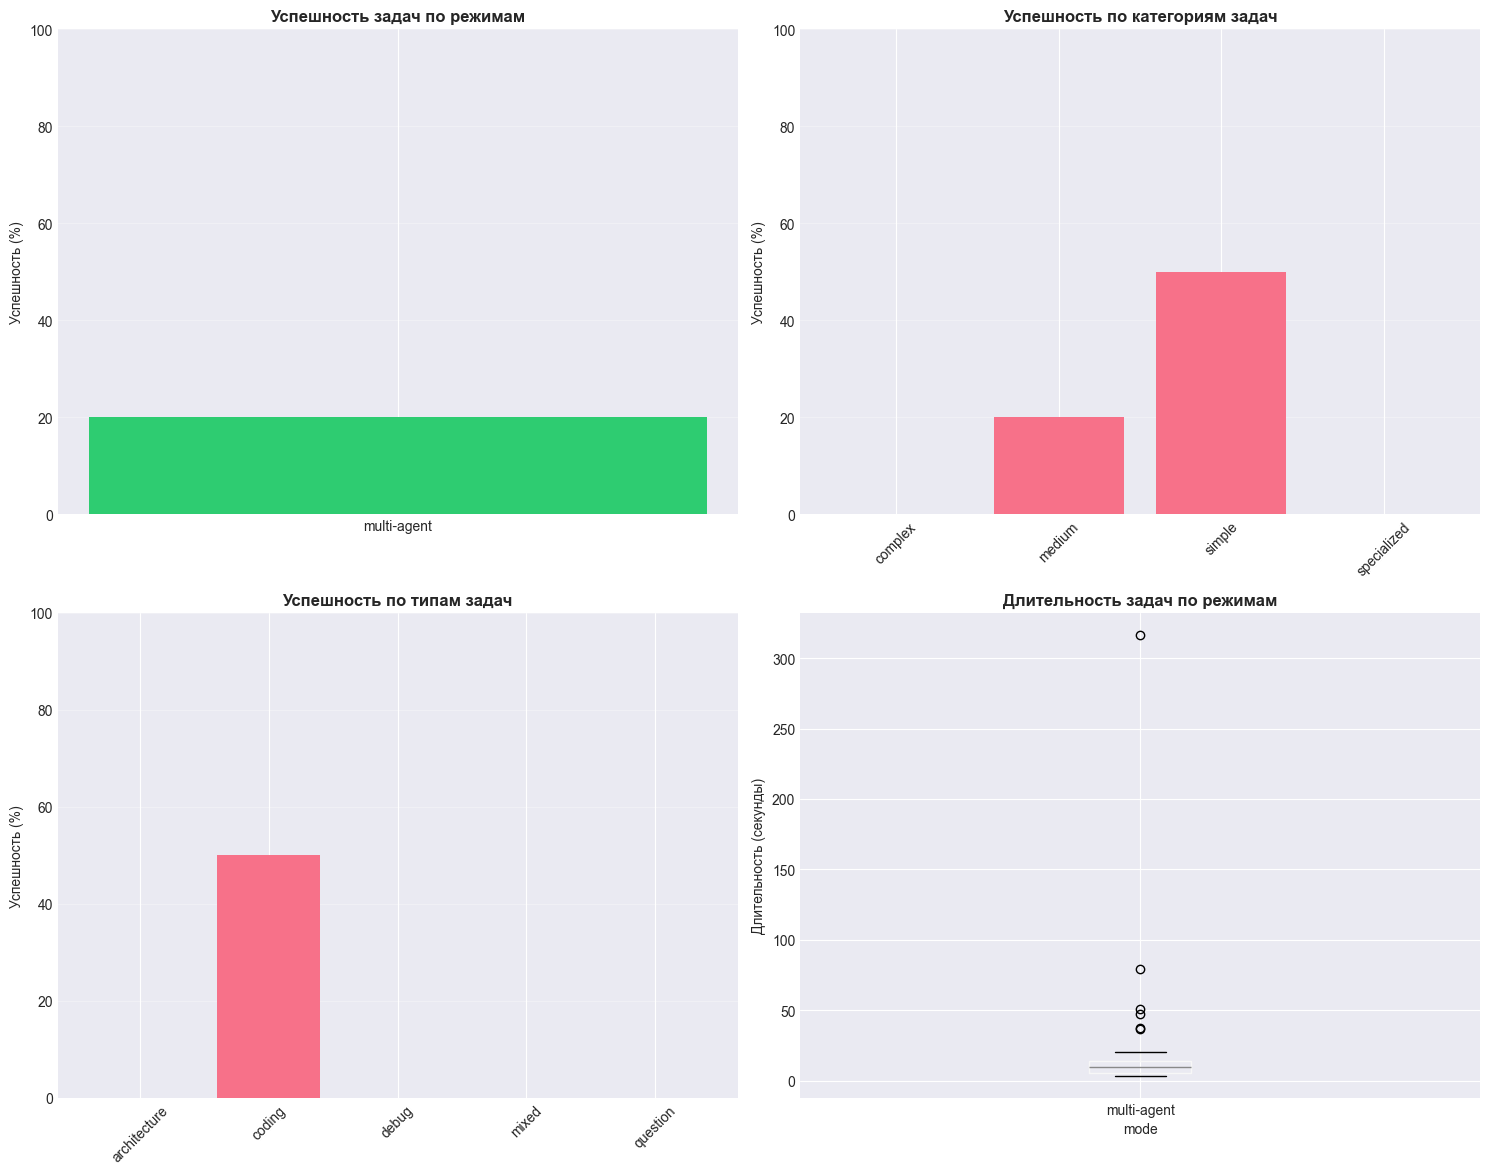

In [8]:
# Визуализация успешности задач
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Успешность по режимам
success_by_mode = task_executions_df.groupby('mode')['success'].agg(['sum', 'count'])
success_by_mode['rate'] = success_by_mode['sum'] / success_by_mode['count'] * 100
axes[0, 0].bar(success_by_mode.index, success_by_mode['rate'], color=['#2ecc71', '#e67e22'])
axes[0, 0].set_title('Успешность задач по режимам', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Успешность (%)')
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(axis='y', alpha=0.3)

# График 2: Успешность по категориям
success_by_category = task_executions_df.groupby('task_category')['success'].agg(['sum', 'count'])
success_by_category['rate'] = success_by_category['sum'] / success_by_category['count'] * 100
axes[0, 1].bar(success_by_category.index, success_by_category['rate'])
axes[0, 1].set_title('Успешность по категориям задач', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Успешность (%)')
axes[0, 1].set_ylim(0, 100)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# График 3: Успешность по типам задач
success_by_type = task_executions_df.groupby('task_type')['success'].agg(['sum', 'count'])
success_by_type['rate'] = success_by_type['sum'] / success_by_type['count'] * 100
axes[1, 0].bar(success_by_type.index, success_by_type['rate'])
axes[1, 0].set_title('Успешность по типам задач', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Успешность (%)')
axes[1, 0].set_ylim(0, 100)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Длительность задач по режимам
if not task_executions_df['duration_seconds'].isna().all():
    task_executions_df.boxplot(column='duration_seconds', by='mode', ax=axes[1, 1])
    axes[1, 1].set_title('Длительность задач по режимам', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Длительность (секунды)')
    plt.suptitle('')
else:
    axes[1, 1].text(0.5, 0.5, 'Нет данных о длительности', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Длительность задач по режимам', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Анализ LLM вызовов

In [9]:
# Статистика по LLM вызовам
print("Статистика по LLM вызовам:")
print(f"Всего вызовов: {len(llm_calls_df)}")
print(f"\nИспользуемые модели:")
print(llm_calls_df['model'].value_counts())

print(f"\nИспользование токенов:")
total_input = llm_calls_df['input_tokens'].sum()
total_output = llm_calls_df['output_tokens'].sum()
print(f"  Всего входных токенов: {total_input:,}")
print(f"  Всего выходных токенов: {total_output:,}")
print(f"  Всего токенов: {total_input + total_output:,}")

print(f"\nСредние значения:")
print(f"  Средние входные токены: {llm_calls_df['input_tokens'].mean():.2f}")
print(f"  Средние выходные токены: {llm_calls_df['output_tokens'].mean():.2f}")

if 'duration_seconds' in llm_calls_df.columns and not llm_calls_df['duration_seconds'].isna().all():
    print(f"  Средняя длительность: {llm_calls_df['duration_seconds'].mean():.2f} сек")

Статистика по LLM вызовам:
Всего вызовов: 145

Используемые модели:
model
openrouter/openai/gpt-4.1    145
Name: count, dtype: int64

Использование токенов:
  Всего входных токенов: 385,467
  Всего выходных токенов: 24,417
  Всего токенов: 409,884

Средние значения:
  Средние входные токены: 2658.39
  Средние выходные токены: 168.39
  Средняя длительность: 3.12 сек


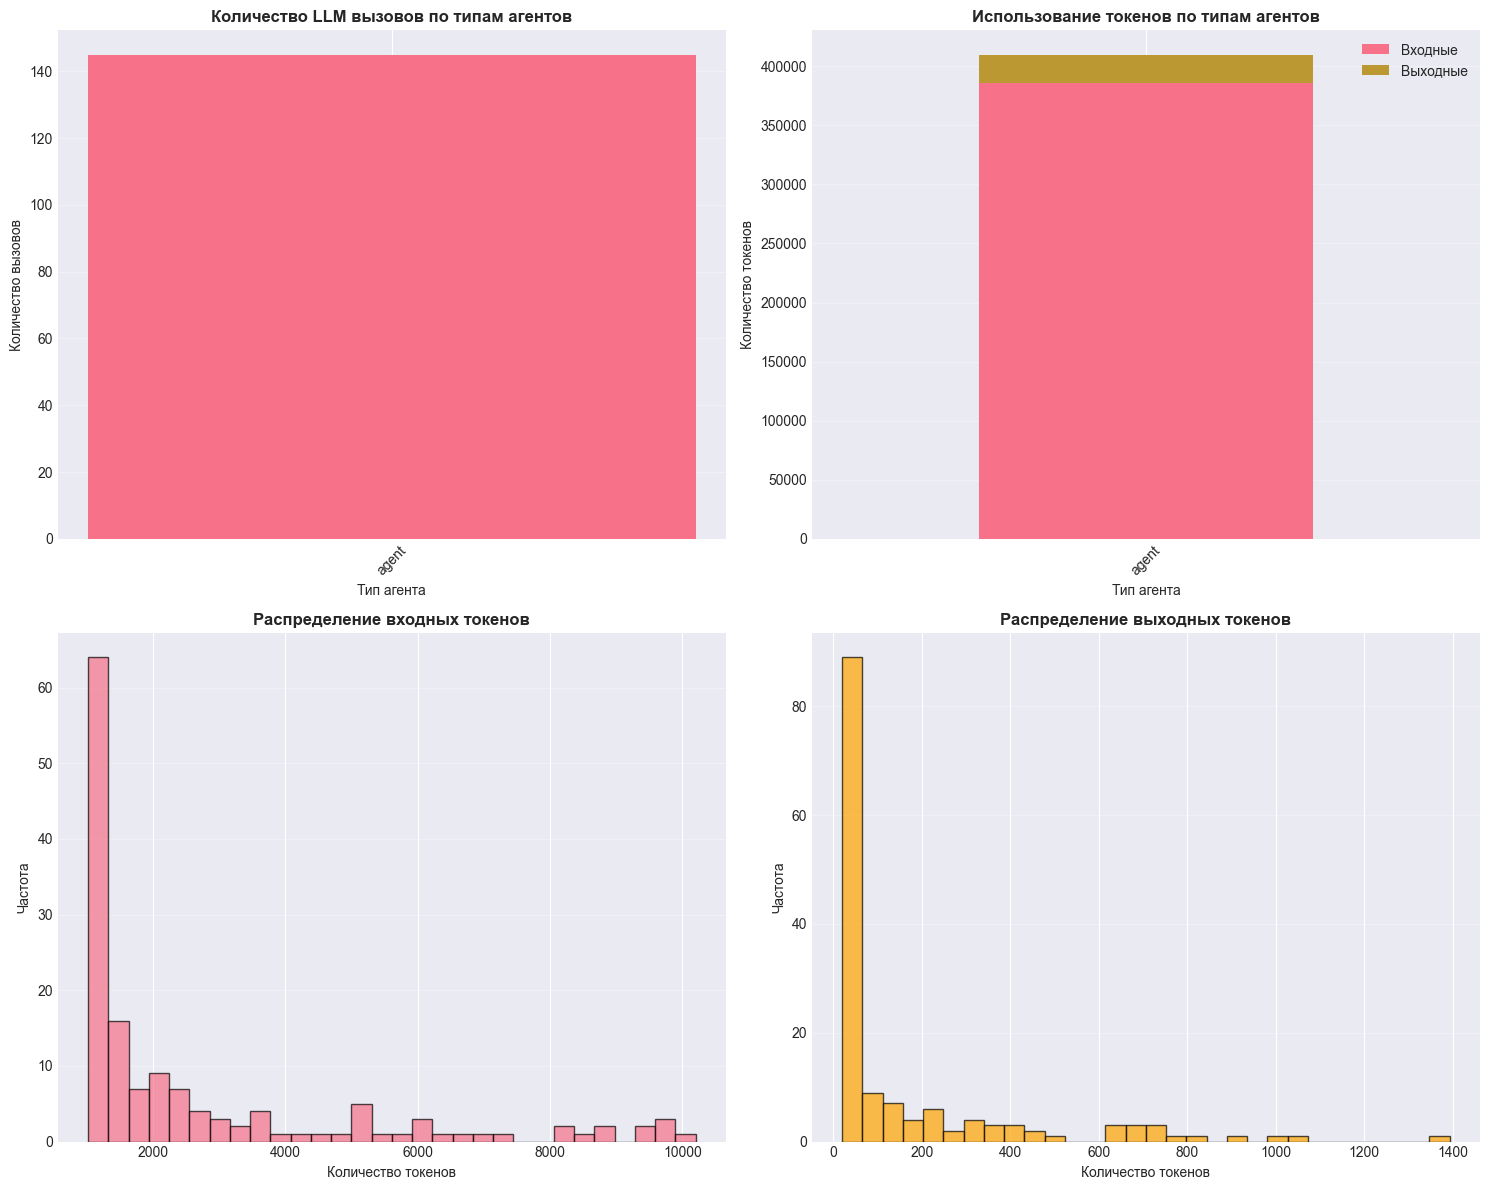

In [10]:
# Визуализация LLM вызовов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Распределение вызовов по агентам
agent_counts = llm_calls_df['agent_type'].value_counts()
axes[0, 0].bar(agent_counts.index, agent_counts.values)
axes[0, 0].set_title('Количество LLM вызовов по типам агентов', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Тип агента')
axes[0, 0].set_ylabel('Количество вызовов')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# График 2: Использование токенов по агентам
tokens_by_agent = llm_calls_df.groupby('agent_type')[['input_tokens', 'output_tokens']].sum()
tokens_by_agent.plot(kind='bar', ax=axes[0, 1], stacked=True)
axes[0, 1].set_title('Использование токенов по типам агентов', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Тип агента')
axes[0, 1].set_ylabel('Количество токенов')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(['Входные', 'Выходные'])
axes[0, 1].grid(axis='y', alpha=0.3)

# График 3: Распределение входных токенов
axes[1, 0].hist(llm_calls_df['input_tokens'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Распределение входных токенов', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Количество токенов')
axes[1, 0].set_ylabel('Частота')
axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Распределение выходных токенов
axes[1, 1].hist(llm_calls_df['output_tokens'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Распределение выходных токенов', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Количество токенов')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Анализ использования инструментов

In [11]:
# Статистика по вызовам инструментов
print("Статистика по вызовам инструментов:")
print(f"Всего вызовов: {len(tool_calls_df)}")
print(f"Успешных: {tool_calls_df['success'].sum()}")
print(f"Неуспешных: {(~tool_calls_df['success']).sum()}")
print(f"\nУспешность: {tool_calls_df['success'].mean() * 100:.2f}%")

print("\nТоп-10 наиболее используемых инструментов:")
print(tool_calls_df['tool_name'].value_counts().head(10))

Статистика по вызовам инструментов:
Всего вызовов: 102
Успешных: 83
Неуспешных: -185

Успешность: 81.37%

Топ-10 наиболее используемых инструментов:
tool_name
read_file           25
list_files          24
write_file          21
execute_command     14
search_in_code      11
create_directory     7
Name: count, dtype: int64


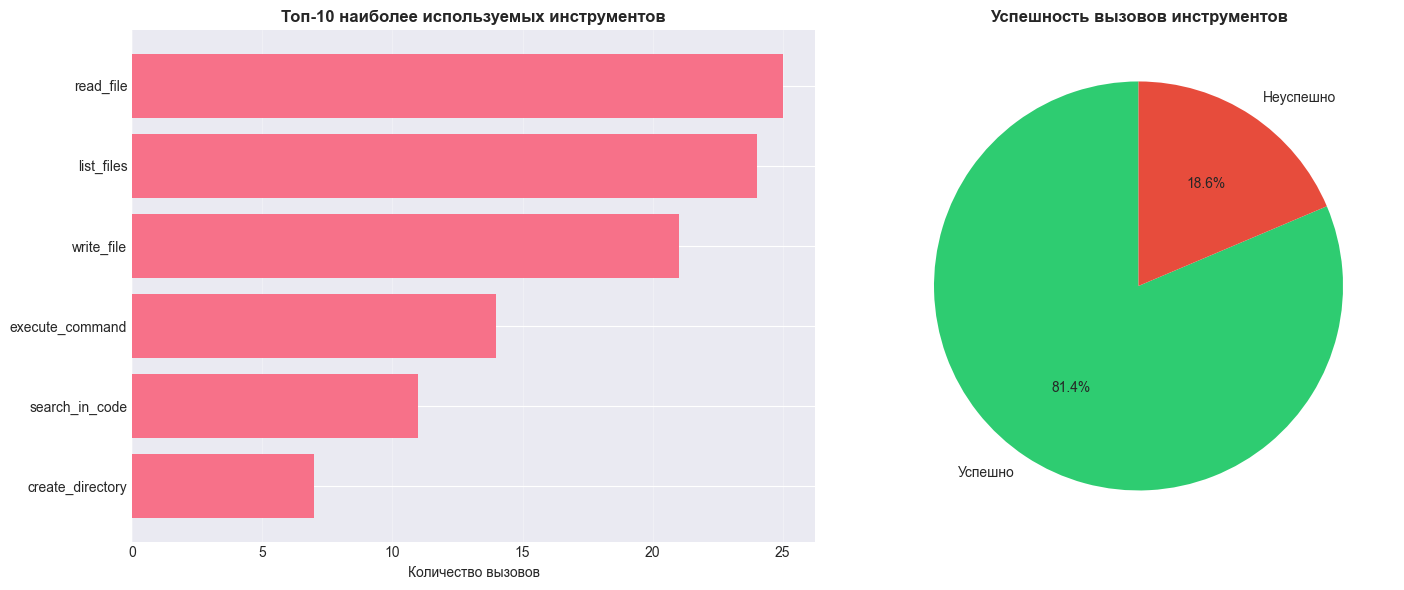

In [12]:
# Визуализация использования инструментов
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Топ-10 инструментов
top_tools = tool_calls_df['tool_name'].value_counts().head(10)
axes[0].barh(range(len(top_tools)), top_tools.values)
axes[0].set_yticks(range(len(top_tools)))
axes[0].set_yticklabels(top_tools.index)
axes[0].set_title('Топ-10 наиболее используемых инструментов', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Количество вызовов')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# График 2: Успешность вызовов инструментов
success_counts = tool_calls_df['success'].value_counts()
axes[1].pie(success_counts.values, labels=['Успешно', 'Неуспешно'], autopct='%1.1f%%',
           colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[1].set_title('Успешность вызовов инструментов', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Анализ переключений агентов

In [13]:
# Статистика по переключениям агентов
print("Статистика по переключениям агентов:")
print(f"Всего переключений: {len(agent_switches_df)}")

if len(agent_switches_df) > 0:
    print("\nНаиболее частые переходы:")
    transitions = agent_switches_df.groupby(['from_agent', 'to_agent']).size().sort_values(ascending=False)
    print(transitions.head(10))
    
    print("\nНаиболее активные целевые агенты:")
    print(agent_switches_df['to_agent'].value_counts())
else:
    print("\nПереключений агентов не обнаружено (возможно, использовался только single-agent режим)")

Статистика по переключениям агентов:
Всего переключений: 43

Наиболее частые переходы:
from_agent    to_agent 
orchestrator  coder        23
              architect     8
              debug         6
              ask           3
ask           ask           2
              coder         1
dtype: int64

Наиболее активные целевые агенты:
to_agent
coder        24
architect     8
debug         6
ask           5
Name: count, dtype: int64


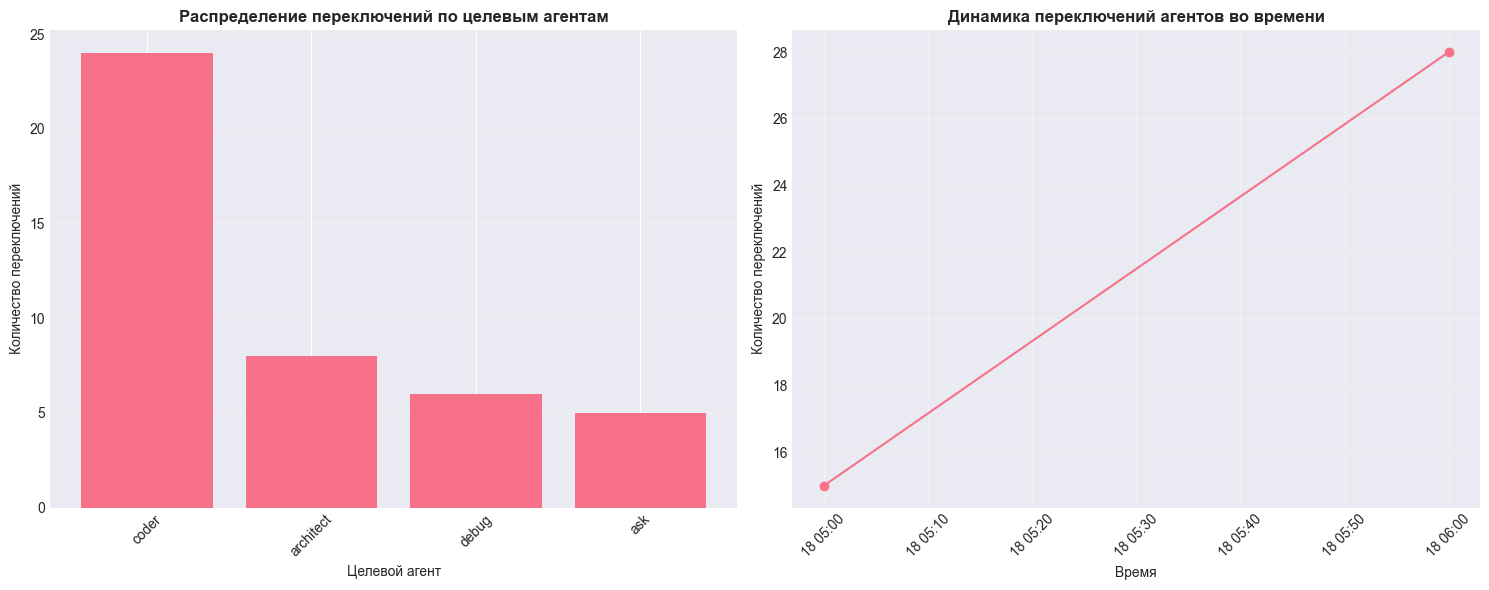

In [14]:
# Визуализация переключений агентов
if len(agent_switches_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # График 1: Распределение по целевым агентам
    to_agent_counts = agent_switches_df['to_agent'].value_counts()
    axes[0].bar(to_agent_counts.index, to_agent_counts.values)
    axes[0].set_title('Распределение переключений по целевым агентам', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Целевой агент')
    axes[0].set_ylabel('Количество переключений')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # График 2: Временная динамика переключений
    agent_switches_df['timestamp'] = pd.to_datetime(agent_switches_df['timestamp'])
    switches_over_time = agent_switches_df.set_index('timestamp').resample('1H').size()
    axes[1].plot(switches_over_time.index, switches_over_time.values, marker='o')
    axes[1].set_title('Динамика переключений агентов во времени', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Время')
    axes[1].set_ylabel('Количество переключений')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для визуализации переключений агентов")

## 8. Оценка качества

In [21]:
# Статистика по оценкам качества
print("Статистика по оценкам качества:")
print(f"Всего оценок: {len(quality_evaluations_df)}")

if len(quality_evaluations_df) > 0:
    print(f"Пройдено: {quality_evaluations_df['passed'].sum()}")
    print(f"Не пройдено: {len(quality_evaluations_df) - quality_evaluations_df['passed'].sum()}")
    print(f"\nПроцент прохождения: {quality_evaluations_df['passed'].mean() * 100:.2f}%")
    
    print("\nТипы оценок:")
    print(quality_evaluations_df['evaluation_type'].value_counts())
    
    if 'score' in quality_evaluations_df.columns and not quality_evaluations_df['score'].isna().all():
        print(f"\nСредний балл: {quality_evaluations_df['score'].mean():.2f}")
        print(f"Медианный балл: {quality_evaluations_df['score'].median():.2f}")
else:
    print("\nОценок качества не обнаружено")

# Статистика по галлюцинациям
print("\n" + "="*50)
print("Статистика по галлюцинациям:")
print(f"Всего обнаружено: {len(hallucinations_df)}")

if len(hallucinations_df) > 0:
    print("\nТипы галлюцинаций:")
    print(hallucinations_df['hallucination_type'].value_counts())
else:
    print("\nГаллюцинаций не обнаружено")

Статистика по оценкам качества:
Всего оценок: 39
Пройдено: 8
Не пройдено: 31

Процент прохождения: 20.51%

Типы оценок:
evaluation_type
auto_check    39
Name: count, dtype: int64

Средний балл: 0.21
Медианный балл: 0.00

Статистика по галлюцинациям:
Всего обнаружено: 0

Галлюцинаций не обнаружено


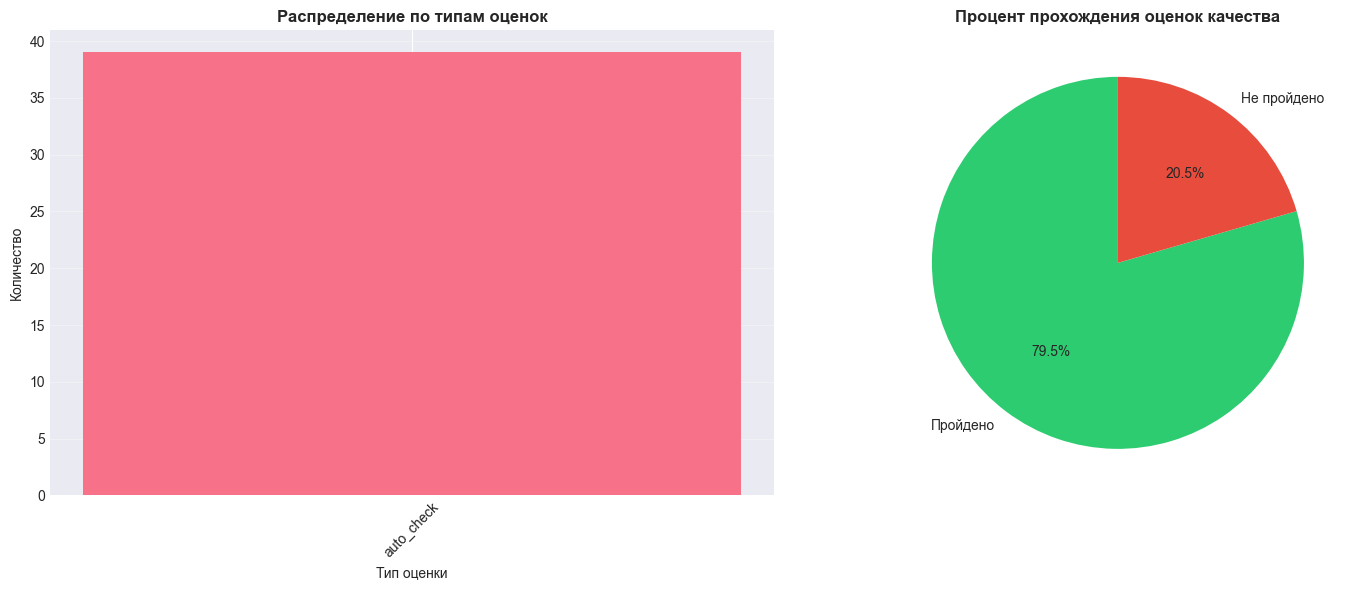

In [16]:
# Визуализация оценок качества
if len(quality_evaluations_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # График 1: Распределение по типам оценок
    eval_type_counts = quality_evaluations_df['evaluation_type'].value_counts()
    axes[0].bar(eval_type_counts.index, eval_type_counts.values)
    axes[0].set_title('Распределение по типам оценок', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Тип оценки')
    axes[0].set_ylabel('Количество')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # График 2: Процент прохождения
    passed_counts = quality_evaluations_df['passed'].value_counts()
    axes[1].pie(passed_counts.values, labels=['Пройдено', 'Не пройдено'], autopct='%1.1f%%',
               colors=['#2ecc71', '#e74c3c'], startangle=90)
    axes[1].set_title('Процент прохождения оценок качества', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для визуализации оценок качества")

## 9. Сравнительный анализ режимов

In [17]:
# Сравнение single-agent и multi-agent режимов
print("Сравнительный анализ режимов:")
print("="*60)

# Объединение данных задач с LLM вызовами
task_llm_merged = task_executions_df.merge(
    llm_calls_df.groupby('task_execution_id').agg({
        'input_tokens': 'sum',
        'output_tokens': 'sum',
        'id': 'count'
    }).rename(columns={'id': 'llm_calls_count'}),
    left_on='id',
    right_index=True,
    how='left'
)

# Объединение с вызовами инструментов
task_tool_merged = task_llm_merged.merge(
    tool_calls_df.groupby('task_execution_id').size().rename('tool_calls_count'),
    left_on='id',
    right_index=True,
    how='left'
)

# Заполнение NaN нулями
task_tool_merged[['llm_calls_count', 'tool_calls_count', 'input_tokens', 'output_tokens']] = \
    task_tool_merged[['llm_calls_count', 'tool_calls_count', 'input_tokens', 'output_tokens']].fillna(0)

# Сравнение по режимам
comparison = task_tool_merged.groupby('mode').agg({
    'success': ['sum', 'count', 'mean'],
    'duration_seconds': 'mean',
    'llm_calls_count': 'mean',
    'tool_calls_count': 'mean',
    'input_tokens': 'mean',
    'output_tokens': 'mean'
})

print("\nСравнение метрик по режимам:")
print(comparison)

# Расчет процента успешности
print("\nУспешность по режимам:")
for mode in task_tool_merged['mode'].unique():
    mode_data = task_tool_merged[task_tool_merged['mode'] == mode]
    success_rate = mode_data['success'].mean() * 100
    print(f"  {mode}: {success_rate:.2f}%")

Сравнительный анализ режимов:

Сравнение метрик по режимам:
            success            duration_seconds llm_calls_count  \
                sum count mean             mean            mean   
mode                                                              
multi-agent       8    40  0.2        21.368464           3.625   

            tool_calls_count input_tokens output_tokens  
                        mean         mean          mean  
mode                                                     
multi-agent             2.55     9636.675       610.425  

Успешность по режимам:
  multi-agent: 20.00%


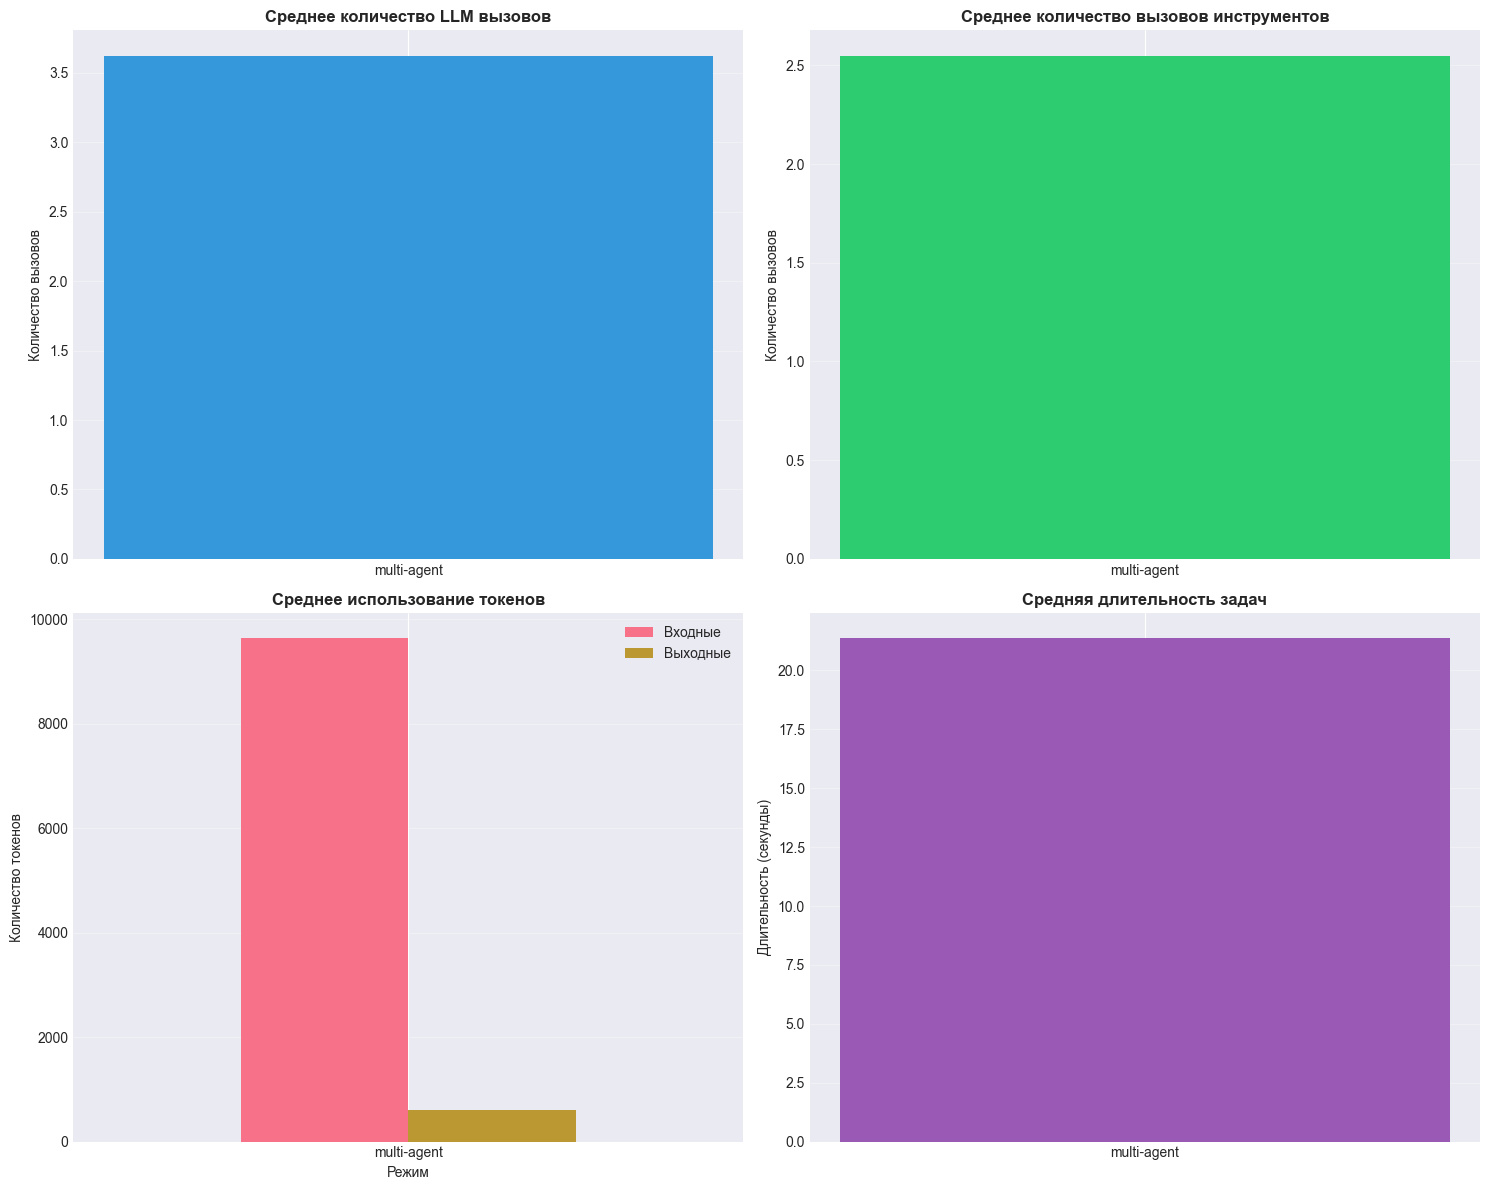

In [18]:
# Визуализация сравнения режимов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Средние LLM вызовы
llm_by_mode = task_tool_merged.groupby('mode')['llm_calls_count'].mean()
axes[0, 0].bar(llm_by_mode.index, llm_by_mode.values, color=['#3498db', '#e74c3c'])
axes[0, 0].set_title('Среднее количество LLM вызовов', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Количество вызовов')
axes[0, 0].grid(axis='y', alpha=0.3)

# График 2: Средние вызовы инструментов
tools_by_mode = task_tool_merged.groupby('mode')['tool_calls_count'].mean()
axes[0, 1].bar(tools_by_mode.index, tools_by_mode.values, color=['#2ecc71', '#f39c12'])
axes[0, 1].set_title('Среднее количество вызовов инструментов', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Количество вызовов')
axes[0, 1].grid(axis='y', alpha=0.3)

# График 3: Средние токены
tokens_by_mode = task_tool_merged.groupby('mode')[['input_tokens', 'output_tokens']].mean()
tokens_by_mode.plot(kind='bar', ax=axes[1, 0], stacked=False)
axes[1, 0].set_title('Среднее использование токенов', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Количество токенов')
axes[1, 0].set_xlabel('Режим')
axes[1, 0].legend(['Входные', 'Выходные'])
axes[1, 0].tick_params(axis='x', rotation=0)
axes[1, 0].grid(axis='y', alpha=0.3)

# График 4: Средняя длительность
if not task_tool_merged['duration_seconds'].isna().all():
    duration_by_mode = task_tool_merged.groupby('mode')['duration_seconds'].mean()
    axes[1, 1].bar(duration_by_mode.index, duration_by_mode.values, color=['#9b59b6', '#1abc9c'])
    axes[1, 1].set_title('Средняя длительность задач', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Длительность (секунды)')
    axes[1, 1].grid(axis='y', alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Нет данных о длительности', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Средняя длительность задач', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Выводы и рекомендации

In [19]:
# Генерация итогового отчета
print("="*70)
print("ИТОГОВЫЙ ОТЧЕТ")
print("="*70)

print("\n1. ОБЩАЯ СТАТИСТИКА:")
print(f"   - Всего экспериментов: {len(experiments_df)}")
print(f"   - Всего выполнено задач: {len(task_executions_df)}")
print(f"   - Общая успешность: {task_executions_df['success'].mean() * 100:.2f}%")
print(f"   - Всего LLM вызовов: {len(llm_calls_df)}")
print(f"   - Всего использовано токенов: {(llm_calls_df['input_tokens'].sum() + llm_calls_df['output_tokens'].sum()):,}")

print("\n2. СРАВНЕНИЕ РЕЖИМОВ:")
for mode in task_executions_df['mode'].unique():
    mode_tasks = task_executions_df[task_executions_df['mode'] == mode]
    mode_llm = llm_calls_df[llm_calls_df['task_execution_id'].isin(mode_tasks['id'])]
    
    print(f"\n   {mode.upper()}:")
    print(f"   - Задач выполнено: {len(mode_tasks)}")
    print(f"   - Успешность: {mode_tasks['success'].mean() * 100:.2f}%")
    print(f"   - LLM вызовов: {len(mode_llm)}")
    print(f"   - Средние токены на задачу: {(mode_llm['input_tokens'].sum() + mode_llm['output_tokens'].sum()) / len(mode_tasks):.0f}")

print("\n3. НАИБОЛЕЕ ИСПОЛЬЗУЕМЫЕ ИНСТРУМЕНТЫ:")
top_5_tools = tool_calls_df['tool_name'].value_counts().head(5)
for i, (tool, count) in enumerate(top_5_tools.items(), 1):
    print(f"   {i}. {tool}: {count} вызовов")

print("\n4. РЕКОМЕНДАЦИИ:")

# Анализ успешности
overall_success = task_executions_df['success'].mean()
if overall_success < 0.7:
    print("   ⚠️  Низкая общая успешность (<70%). Рекомендуется:")
    print("      - Проанализировать причины неудач")
    print("      - Улучшить промпты и инструкции для агентов")
    print("      - Добавить больше примеров в контекст")
elif overall_success < 0.9:
    print("   ℹ️  Средняя успешность (70-90%). Есть потенциал для улучшения.")
else:
    print("   ✅ Высокая успешность (>90%). Система работает хорошо.")

# Анализ использования токенов
avg_tokens_per_task = (llm_calls_df['input_tokens'].sum() + llm_calls_df['output_tokens'].sum()) / len(task_executions_df)
if avg_tokens_per_task > 50000:
    print("\n   ⚠️  Высокое использование токенов. Рекомендуется:")
    print("      - Оптимизировать промпты")
    print("      - Уменьшить размер контекста")
    print("      - Использовать кэширование")

# Анализ переключений агентов
if len(agent_switches_df) > 0:
    avg_switches = len(agent_switches_df) / len(task_executions_df[task_executions_df['mode'] == 'multi-agent'])
    if avg_switches > 5:
        print("\n   ⚠️  Много переключений между агентами. Рекомендуется:")
        print("      - Улучшить логику выбора агента")
        print("      - Оптимизировать специализацию агентов")

print("\n" + "="*70)
print("Анализ завершен!")
print("="*70)

ИТОГОВЫЙ ОТЧЕТ

1. ОБЩАЯ СТАТИСТИКА:
   - Всего экспериментов: 1
   - Всего выполнено задач: 40
   - Общая успешность: 20.00%
   - Всего LLM вызовов: 145
   - Всего использовано токенов: 409,884

2. СРАВНЕНИЕ РЕЖИМОВ:

   MULTI-AGENT:
   - Задач выполнено: 40
   - Успешность: 20.00%
   - LLM вызовов: 145
   - Средние токены на задачу: 10247

3. НАИБОЛЕЕ ИСПОЛЬЗУЕМЫЕ ИНСТРУМЕНТЫ:
   1. read_file: 25 вызовов
   2. list_files: 24 вызовов
   3. write_file: 21 вызовов
   4. execute_command: 14 вызовов
   5. search_in_code: 11 вызовов

4. РЕКОМЕНДАЦИИ:
   ⚠️  Низкая общая успешность (<70%). Рекомендуется:
      - Проанализировать причины неудач
      - Улучшить промпты и инструкции для агентов
      - Добавить больше примеров в контекст

Анализ завершен!


In [20]:
# Закрытие соединения с базой данных
conn.close()
print("✓ Соединение с базой данных закрыто")

✓ Соединение с базой данных закрыто


## Выводы по итоговому отчету

По результатам эксперимента можно сказать, что **Multi-Agent система в текущем виде работает плохо и не доказывает свою пользу**.

### Что получилось на практике

* Было выполнено **40 задач**, но успешно решены только **8 из 40**
  → это **всего 20% успеха**, что очень мало.
* Система **часто обращалась к языковой модели** (145 раз).
* При этом было потрачено **очень много токенов** — более **400 тысяч**.
* В среднем на одну задачу уходило **около 10 тысяч токенов**, но это редко приводило к успешному результату.

Проще говоря:

> **система много «думает», но редко решает задачу правильно**.

---

### Как система использует инструменты

Агенты чаще всего:

* читают файлы,
* смотрят список файлов,
* что-то записывают в файлы,
* запускают команды.

Это выглядит так, будто система **пытается наугад разобраться в проекте**, вместо того чтобы:

1. понять задачу,
2. составить план,
3. выполнить шаги по порядку.

---

### В чем основная проблема

Проблема **не в том, что модель “плохо отвечает”** и не в том, что «нужны лучшие промпты».

Главная проблема в том, что:

* у системы **нет чёткого плана действий**,
* она **не проверяет**, получилось ли выполнить шаг,
* она **не останавливается**, если зашла в тупик.

Из-за этого система:

* тратит много ресурсов,
* долго работает,
* но часто всё равно не справляется.

---

### Почему это важно

При таких результатах:

* систему **нельзя показывать пользователям**,
* её **нельзя считать успешным прототипом**,
* её **нельзя сравнивать с обычным Single-Agent решением**.

На этом этапе Multi-Agent даёт **больше сложности, чем пользы**.

---

### Что логично делать дальше

Перед тем как развивать Multi-Agent, стоит:

1. Сначала сделать **простую версию с одним агентом**, которая:

   * решает хотя бы **большинство задач**,
   * делает это быстрее и дешевле.

2. Добавить базовую логику:

   * план действий,
   * проверку результата,
   * остановку, если решение не получается.

3. И только после этого думать о нескольких агентах.

---

### Итог

> Сейчас Multi-Agent система выглядит как сложный механизм,
> который много работает, но редко приносит результат.

На данном этапе эксперимент показал **проблемы в логике работы системы**, а не её преимущества.
